# *Components of this project*
 ***    
     1- EXPLORATORY DATA ANALYSIS
     2- FEATURE ENGINEERING
     3- DATA CLEANING
     4- ENCODING CATEGORICAL FEATURES
     5- MACHINE LEARNING

In [1]:

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('whitegrid')
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.
pd.options.mode.chained_assignment = None # Warning for chained copies disabled

from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
import sklearn.metrics as sklm
from sklearn import feature_selection as fs
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

import numpy.random as nr
import scipy.stats as ss
import math

import warnings
warnings.simplefilter(action='ignore')

%matplotlib inline

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


***
Let's open our train and test datasets:

In [2]:
a = pd.read_csv("/kaggle/input/titanic/train.csv")
b = pd.read_csv("/kaggle/input/titanic/test.csv")

We merge both datasets to apply data cleaning and encoding on both train and test dataset to make sure they were processed equally. 
#### I will be using alphabets to name my datasets to make my workflow easier:
             a=train
             b=test
             c= combined dataset (train+test)

In [3]:
na = a.shape[0] #Shape of train, to be used later to split the combined dataset
nb = b.shape[0]
frames= [a,b]
#Combine train and test sets
c1=pd.concat(frames, axis=0, sort=False).reset_index(drop=True)
#Drop the target "Survived" from the combined dataset
target = a[['Survived']]
c1.drop(['Survived'], axis=1, inplace=True)
print("The shape of the training set is", na)
print("Total size is :",c1.shape)

The shape of the training set is 891
Total size is : (1309, 11)


In [4]:
print(c1.isnull().sum())

PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64


#### Cabin, age and embarked columns have missing values that will be treated later on. Let's start data exploration

# 1- EXPLORATORY DATA ANALYSIS:
***

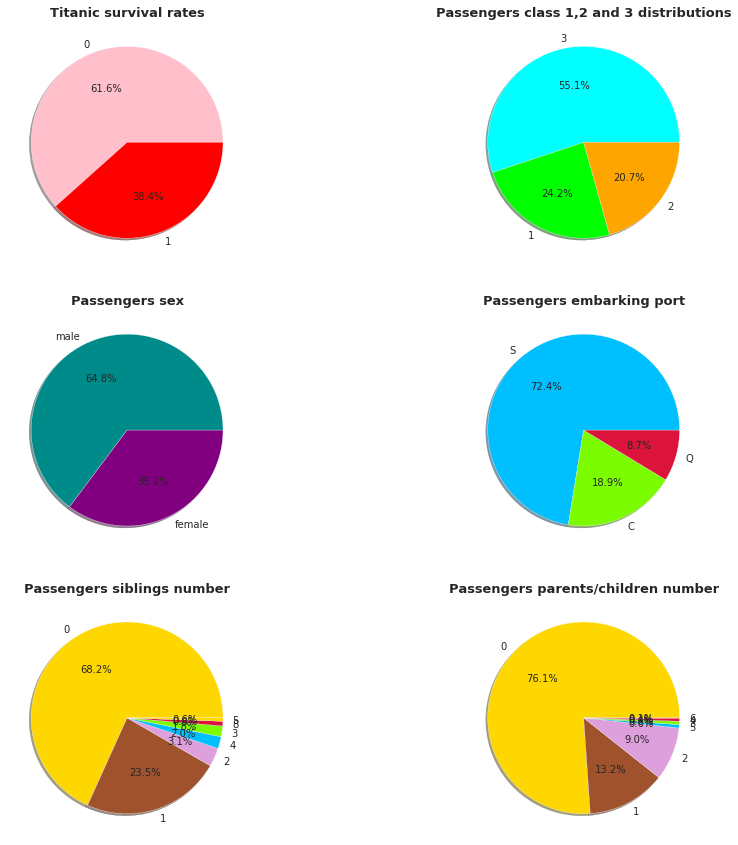

In [5]:
Survived=a['Survived'].value_counts()
Survived=pd.DataFrame(Survived)
Survived=Survived.reset_index()

pclass= a['Pclass'].value_counts()
pclass= pd.DataFrame(pclass)
pclass= pclass.reset_index()

sex= a['Sex'].value_counts()
sex= pd.DataFrame(sex)
sex= sex.reset_index()

embarked=a['Embarked'].value_counts()
embarked= pd.DataFrame(embarked)
embarked= embarked.reset_index()

sibling=a['SibSp'].value_counts()
sibling= pd.DataFrame(sibling)
sibling= sibling.reset_index()

parch=a['Parch'].value_counts()
parch= pd.DataFrame(parch)
parch= parch.reset_index()
plt.style.use('seaborn')
sns.set_style('whitegrid')
fig = plt.figure(figsize=(15,15))
ax1 = plt.subplot2grid((3,2),(0,0))
plt.pie(Survived.Survived,colors=("pink","r"), autopct='%2.1f%%',labels=Survived['index'], shadow=True)
plt.title('Titanic survival rates', fontsize=13, weight='bold' )

ax1 = plt.subplot2grid((3,2),(0,1))
plt.pie(pclass.Pclass,colors=("cyan","lime", 'orange'), autopct='%2.1f%%',labels=pclass['index'], shadow=True)
plt.title('Passengers class 1,2 and 3 distributions', fontsize=13, weight='bold' )

ax1 = plt.subplot2grid((3,2),(1,0))
plt.pie(sex.Sex,colors=("darkcyan","purple"), autopct='%2.1f%%',labels=sex['index'], shadow=True)
plt.title('Passengers sex', fontsize=13, weight='bold' )

ax1 = plt.subplot2grid((3,2),(1,1))
plt.pie(embarked.Embarked,colors=("deepskyblue","lawngreen", 'crimson'), autopct='%2.1f%%',labels=embarked['index'], shadow=True)
plt.title('Passengers embarking port', fontsize=13, weight='bold' )

ax1 = plt.subplot2grid((3,2),(2,0))
plt.pie(sibling.SibSp,colors=("gold","sienna","plum","deepskyblue","lawngreen", 'crimson'), autopct='%2.1f%%',labels=sibling['index'], shadow=True)
plt.title('Passengers siblings number', fontsize=13, weight='bold' )

ax1 = plt.subplot2grid((3,2),(2,1))
plt.pie(parch.Parch,colors=("gold","sienna","plum","deepskyblue","lawngreen", 'crimson', 'red'), autopct='%2.1f%%',labels=parch['index'], shadow=True)
plt.title('Passengers parents/children number', fontsize=13, weight='bold' )


plt.show()

#### Notes:
***
* 62% of the passengers didn't survive and the remaining 38% survived, we have a class imbalance here, to be taken into consideration later on while tuning the model.
* Most of the passengers were located in Pclass3
* There are more male (64%) than female (36%)
* Most of the passengers (72%) embarked from the S port
* Most of the passengers are alone without siblings, children or parents

Next we check the survival rates in each Pclass:

> ### 1- PClass

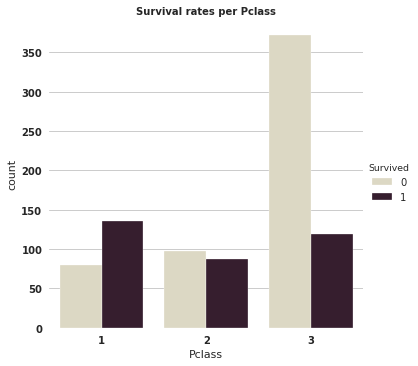

In [6]:
sns.catplot(x='Pclass', kind='count',hue='Survived', data=a, palette='ch:.384')
plt.title('Survival rates per Pclass', fontsize=10, weight='bold' )
plt.xticks(weight='bold')
plt.yticks(weight='bold')
plt.show()

1. Passengers in Pclass 1 have a higher survival chance than passengers in the other Pclasses.
2. Passengers in Pclass 2 have the lowest survival rates.
3. Pclass3 housed more passengers since it's the cheapest Pclass. The unsurvival rates are very high in this class, which will definitely be a good feature for our prediction model.


> ### 2- Sex

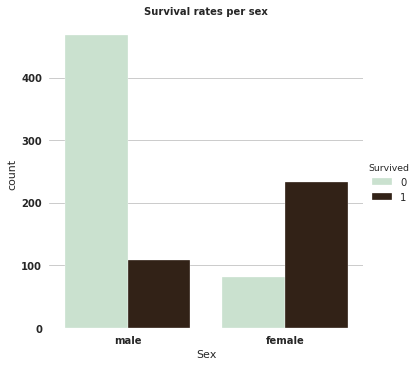

In [7]:
sns.catplot(x='Sex', kind='count',hue='Survived', data=a, palette='ch:.991')
plt.title('Survival rates per sex', fontsize=10, weight='bold' )
plt.xticks(weight='bold')
plt.yticks(weight='bold')
plt.show()

Female passengers have a higher survival rate than male passengers, another important feature for our model

> ### 3- Age

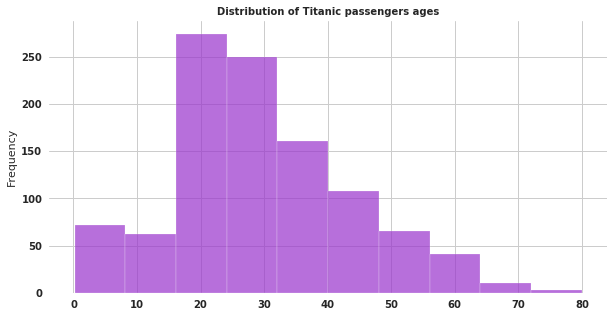

In [8]:
sns.set_style('whitegrid')
f,ax=plt.subplots(figsize=(10,5))
c1['Age'].plot(kind='hist', color='darkorchid', alpha=0.7)
plt.title('Distribution of Titanic passengers ages', fontsize=10, weight='bold' )
plt.xticks(weight='bold')
plt.yticks(weight='bold')
plt.show()

The passengers age distribution indicates that the majority of passengers are young, in their 20s and 30s.

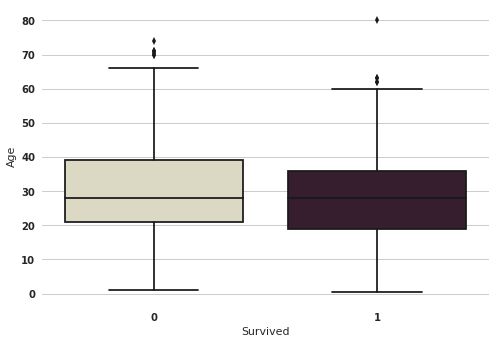

In [9]:
sns.boxplot(y='Age', x='Survived', data=a, palette='ch:.39041')
plt.xticks(weight='bold')
plt.yticks(weight='bold')
plt.show()

We can tell from the boxplot that the survivors tend to be slightly younger, we can't see a significant difference, given that most of the passengers are young people, but this information would be useful to build our model

> ### 4- Sibling/Spouse

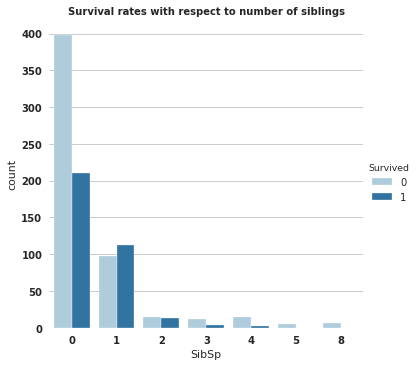

In [10]:

sns.catplot(x='SibSp', kind='count',hue='Survived', data=a, palette='Paired')
plt.title('Survival rates with respect to number of siblings', fontsize=10, weight='bold' )
plt.xticks(weight='bold')
plt.yticks(weight='bold')
plt.show()

* Passengers with 1 or 2 siblings have a solid chance of survival
* Passengers with 5 and 8 siblings are probably outliers, we will take care of it later on.

> ### 5- Parent/children

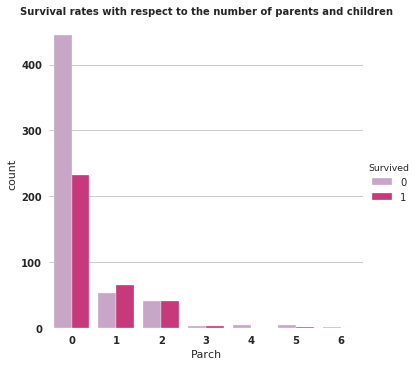

In [11]:
sns.catplot(x='Parch', kind='count',hue='Survived', data=a, palette='PuRd')
plt.title('Survival rates with respect to the number of parents and children', fontsize=10, weight='bold' )
plt.xticks(weight='bold')
plt.yticks(weight='bold')
plt.show()

Same as with siblings, passengers with 1 or 2 parent/children have a solid chance of survival, this information will be useful to build our model

> ### 6- Fare

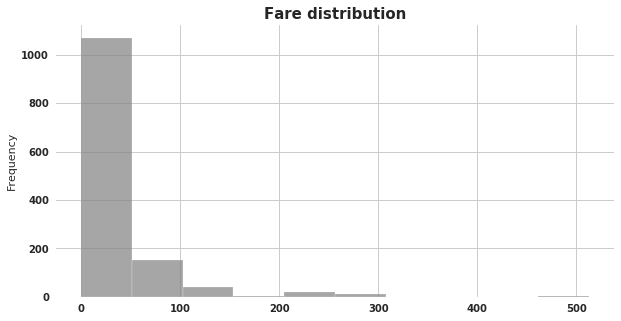

In [12]:
sns.set_style('whitegrid')
fig = plt.figure(figsize=(10,5))
c1['Fare'].plot(kind='hist', color='grey', alpha=0.7)
plt.title('Fare distribution', fontsize=15, weight='bold' )
plt.xticks(weight='bold')
plt.yticks(weight='bold')
plt.show()


* We have a clear fare distribution between 0 and 150. The cheapest fares are related to Pclass3 that housed the pajority of passengers, the fares around 100 must be related to Pclass1 and Pclass2.
* Fares higher than 200 are outliers.

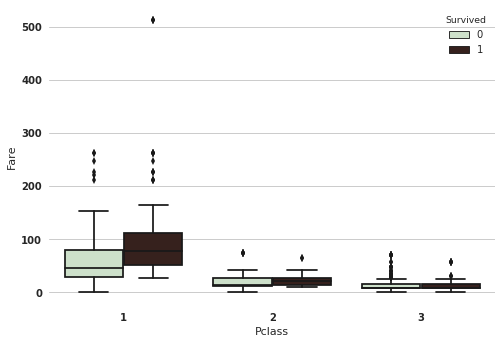

In [13]:
sns.set_style('whitegrid')
sns.boxplot(x='Pclass', y='Fare',hue='Survived', palette='ch:.838', data=a)
plt.xticks(weight='bold')
plt.yticks(weight='bold')
plt.show()

* As expected, Pclass1 had the highest fares, followed by Pclass2. Pclass3 comes last with the cheapest fares
* Passengers in Pclass1 have a higher survival chance.
* Pclass1 passengers that survived have paid higher fares than the ones that didn't survive in the same Pclass1, this means that fare is an important feature for our predictions.

> ### 7- Embarking Port

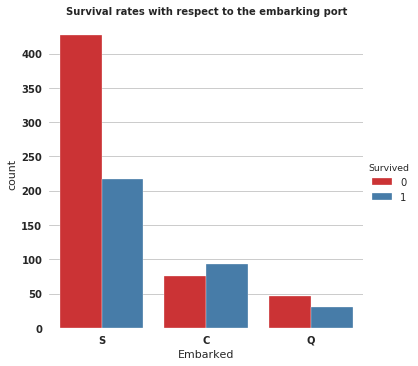

In [14]:
sns.catplot(x='Embarked', kind='count',hue='Survived', data=a, palette='Set1')
plt.title('Survival rates with respect to the embarking port', fontsize=10, weight='bold' )
plt.xticks(weight='bold')
plt.yticks(weight='bold')
plt.show()


* Most passengers embarked from S port
* Passengers that embarked from C port have a higher survival chance.

# 2- Feature engineering:
***
Create a new feature: Family size which includes the passenger and his siblings, parents and children

In [15]:
c1['family_size']=c1['SibSp'] + c1['Parch'] + 1

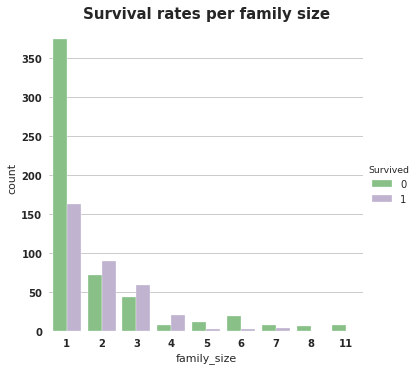

In [16]:
a['family_size']=a['SibSp'] + a['Parch'] + 1
sns.catplot(x='family_size', kind='count',hue='Survived', data=a, palette='Accent')
plt.title('Survival rates per family size', fontsize=15, weight='bold' )
plt.xticks(weight='bold')
plt.yticks(weight='bold')
plt.show()

Passengers that have a family of 2,3 and 4 members have a solid chance to survive



# 3- Data cleaning:
***

In [17]:
c1.isnull().sum()

PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
family_size       0
dtype: int64

We drop the cabin feature because it has more than 80% missing values, those missing values could be because most of the passengers in Pclass3 didn't have a cabin, but for a simpler model, the cabin feature is dropped.

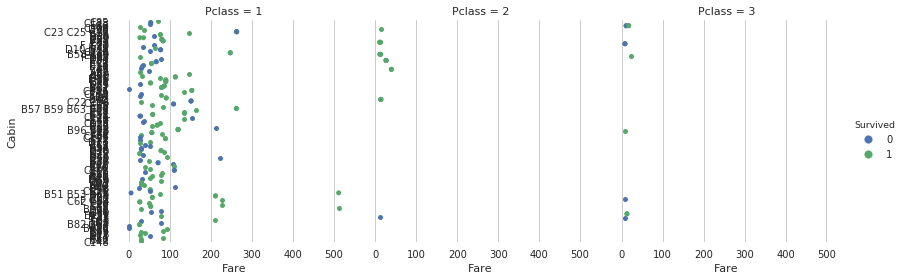

In [18]:
sns.catplot(y='Cabin', x='Fare',height=4, hue='Survived', col='Pclass', data=a)
plt.show()

In [19]:
c=c1.drop('Cabin', axis=1)

We fill the "Age" missing values with the median: 28

In [20]:
c['Age'].fillna(28, inplace=True)

The "Embarked" and "Fare" columns have 2 and 1 missing values respectively. We will apply the forward fill method to fill the missing values

In [21]:
c['Embarked'].fillna(method='ffill', inplace=True)

In [22]:
c['Fare'].fillna(method='ffill', inplace=True)

In [23]:
#We cleaned our combined dataset from missing values
print(c.isnull().sum())

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
family_size    0
dtype: int64


# 4- Encode categorical feature:
***
* We encode the "Embarked" feature with a one hot encoder
* We also encode the "Pclass" feature. On theory, it's a numerical feature but we don't want to confuse our model, 1, 2 and 3 are just the labels of the P. classes and not a given numerical value
* Encode Sex: 0=Male and 1=Female

In [24]:
#First, we keep just the features that will be used in Machine Learning
c2=c[['Pclass','Sex','Age','Embarked','family_size','Parch','SibSp', 'Fare']]

#Change the data type of Pclass to object
c2['Pclass']=c2['Pclass'].astype(object)

In [25]:
c3=pd.get_dummies(c2)
print("the shape of the original dataset",c2.shape)
print("the shape of the encoded dataset",c3.shape)
print("We have ",c3.shape[1]- c2.shape[1], 'new encoded features')

the shape of the original dataset (1309, 8)
the shape of the encoded dataset (1309, 13)
We have  5 new encoded features


> #### A quick look over the encoded features

In [26]:
c3.sample(2)

,Age,family_size,Parch,SibSp,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
684,60.0,3,1,1,39.0000,0,1,0,0,1,0,0,1
1047,29.0,1,0,0,221.7792,1,0,0,1,0,0,0,1


Now, after we cleaned and encoded the combined data set, we split them to the original train and test data 

In [27]:
#Splitting the combined dataset to the original train and test datasets
Train = c3[:na]  #na is the number of rows of the original training set
Test = c3[na:] 

> ### Outliers detection:

Next thing to do is: Find the outliers
* "Fare" and "sibSp" features seem to have some outliers

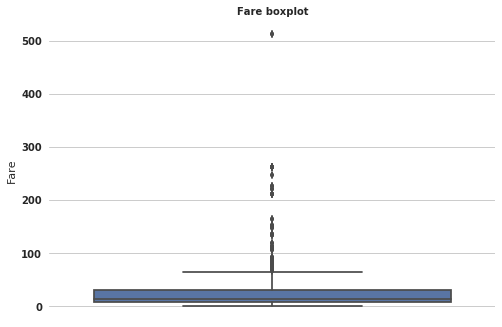

In [28]:
sns.boxplot(y='Fare', data=c)
plt.title('Fare boxplot', fontsize=10, weight='bold' )
plt.xticks(weight='bold')
plt.yticks(weight='bold')
plt.show()

Let's localise those outliers

In [29]:
s=a[['Pclass','Fare','Survived']]
s.sort_values(by='Fare', ascending=False).head(10)

,Pclass,Fare,Survived
258,1,512.3292,1
737,1,512.3292,1
679,1,512.3292,1
88,1,263.0000,1
27,1,263.0000,0
341,1,263.0000,1
438,1,263.0000,0
311,1,262.3750,1
742,1,262.3750,1
118,1,247.5208,0


Interesting!!! All the passengers with fares higher than 200 were in Pclass1. Probably those are not outliers but simply passengers that paid for an exclusive premium service since they already belong to the premium Pclass1. However, those values might disturb our model, so we will drop them.

In [30]:
Train['Fare'].sort_values(ascending=False).head(20)

679    512.3292
258    512.3292
737    512.3292
341    263.0000
438    263.0000
88     263.0000
27     263.0000
311    262.3750
742    262.3750
299    247.5208
118    247.5208
716    227.5250
557    227.5250
380    227.5250
700    227.5250
527    221.7792
377    211.5000
689    211.3375
730    211.3375
779    211.3375
Name: Fare, dtype: float64

In [31]:
Train1=Train[Train['Fare'] < 200]

In [32]:
print('We dropped ',Train.shape[0] - Train1.shape[0],'fare outliers')

We dropped  20 fare outliers


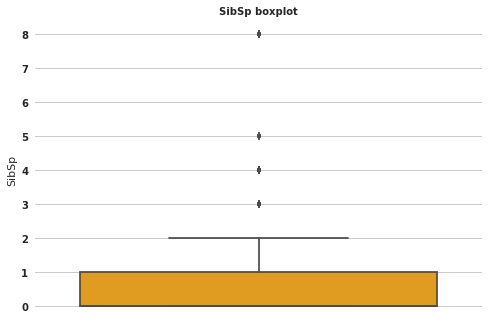

In [33]:
sns.boxplot(y='SibSp', data=c2, color='orange')
plt.title('SibSp boxplot', fontsize=10, weight='bold' )
plt.xticks(weight='bold')
plt.yticks(weight='bold')
plt.show()

In [34]:
Train1['SibSp'].sort_values(ascending=False).head(7)

863    8
846    8
159    8
792    8
180    8
324    8
201    8
Name: SibSp, dtype: int64

Apparently the data of passengers having more than 5 siblings are outliers, we filter our rows and keep just the "SibSp" less or equal to 5

In [35]:
train=Train1[Train1['SibSp'] <= 5]

In [36]:
print('We dropped ', Train1.shape[0]- train.shape[0], 'sibSp outliers')
print('And in total, we dropped ', Train.shape[0]-train.shape[0], 'outliers')

We dropped  7 sibSp outliers
And in total, we dropped  27 outliers


Great! We dropped all the outliers **from the train dataset** now we have to localize those outliers and drop them from the **target** (survived) to keep the same shape of the train and target sets

In [37]:
print(train.shape, target.shape)

(864, 13) (891, 1)


In [38]:
#Index positions are taken from the above 2 list of outiers (Fare and SibSp)
pos=[863,846,159,792,180,324,201, 679, 258, 737, 341,438,88,27,311,742,299, 118,
     716,557,380,700,527,377,698,730,779]
target.drop(target.index[pos], inplace=True)

print("Shape of training dataset",train.shape[0])
print("Shape of target", target.shape[0])

Shape of training dataset 864
Shape of target 864


> ### Correlation between our features:

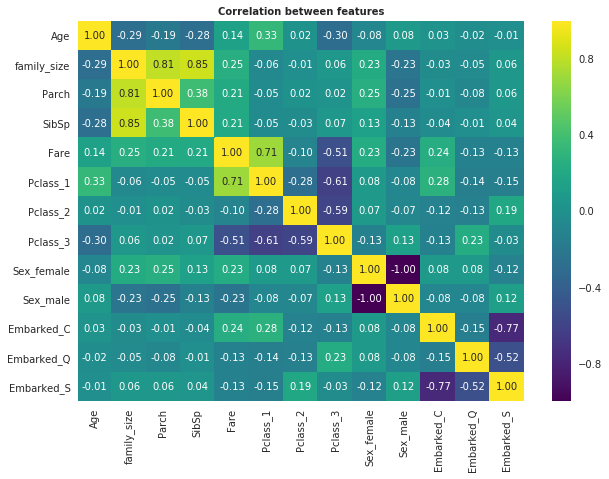

In [39]:
f,ax=plt.subplots(figsize=(10,7))
sns.heatmap(train.corr(), annot=True, fmt = ".2f", cmap='viridis')
plt.title('Correlation between features', fontsize=10, weight='bold' )
plt.show()

In [40]:
train.sample(5)

,Age,family_size,Parch,SibSp,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
144,18.0,1,0,0,11.5000,0,1,0,0,1,0,0,1
85,33.0,4,0,3,15.8500,0,0,1,1,0,0,0,1
166,28.0,2,1,0,55.0000,1,0,0,1,0,0,0,1
511,28.0,1,0,0,8.0500,0,0,1,0,1,0,0,1
375,28.0,2,0,1,82.1708,1,0,0,1,0,1,0,0


Both training and testing datasets are clean and encoded. Everything is ready to start building Machine Learning Models

# 5- Machine Learning:
*** 
> ### 5.1 Preprocessing:

We split our data to:
* Features: x 
* Labels: y

In [41]:
x=train
y=np.array(target)

Split them to train and test subsets

In [42]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size = .33, random_state=0)

We first scale our data, since some features such as "Age" and "Fare" have higher values than the rest of the features

In [43]:
from sklearn.preprocessing import StandardScaler
scaler= StandardScaler()
# transform "x_train"
x_train = scaler.fit_transform(x_train)
# transforming "x_test"
x_test = scaler.transform(x_test)

# transforming "test (dataset)"
test = scaler.transform(Test)

In [44]:
#We will need those libraries 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report



> ### 5.1 Logistic regression
* We have unbalanced classes: 62% didn't survive and 38% survived, we tune the model such as it considers this class unbalance: class_weight={0:0.62, 1:0.38}
* C=1 is the default parameter, we will try to tune it using gridSearch for better results

In [45]:
from sklearn.linear_model import LogisticRegression

lr_c=LogisticRegression( C=1, class_weight={0:0.62, 1:0.38}, max_iter=5000,
                     penalty='l2',
                   random_state=None, solver='lbfgs', verbose=0,
                   warm_start=True)
lr_c.fit(x_train,y_train.ravel())
lr_pred=lr_c.predict(x_test)
lr_ac=accuracy_score(y_test.ravel(), lr_pred)
print('LogisticRegression_accuracy test:',lr_ac)
print("AUC",roc_auc_score(y_test.ravel(), lr_pred))

LogisticRegression_accuracy test: 0.7937062937062938
AUC 0.7562522842374563


> ### 5.2 Cross-Validation

We use cross validation to validate our accuracy score, we run the model 15 times on 15 chunks leaving one chunck each time for validation

In [46]:
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score
cv = StratifiedShuffleSplit(n_splits = 15, test_size = .25, random_state = 0 ) # run model 10x with 60/30 split intentionally leaving out 10%

x = scaler.fit_transform(x)
accuracies = cross_val_score(LogisticRegression(solver='liblinear',class_weight={0:0.62, 1:0.38}), x,y, cv  = cv)
print ("CV accuracy on 15 chunks: {}".format(accuracies))
print ("Mean CV accuracy: {}".format(round(accuracies.mean(),5)))

CV accuracy on 15 chunks: [0.81018519 0.81018519 0.77314815 0.79166667 0.82407407 0.79166667
 0.77314815 0.77777778 0.80092593 0.77777778 0.79166667 0.7962963
 0.7962963  0.77777778 0.81018519]
Mean CV accuracy: 0.79352


> ### 5.3 Support vector machine:

In [47]:
from sklearn import svm 
from sklearn.svm import SVC, LinearSVC


svm=SVC(kernel='rbf',C=10,gamma=0.1)
svm.fit(x_train,y_train.ravel())
svm_pred=svm.predict(x_test)
print('Accuracy is ',metrics.accuracy_score(svm_pred,y_test.ravel()))
print('AUC: ',roc_auc_score(y_test.ravel(), svm_pred))

Accuracy is  0.7972027972027972
AUC:  0.7609251814337179


> ### 5.4 GridSearch: Hyperparameter tuning
We tune our model's hyperparamters using GridSearchCV to find the best parameters "gamma" and "C"

In [48]:
SVMC = SVC(probability=True,class_weight={0:0.62, 1:0.38})
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001,0.008, 0.01,0.02,0.05, 0.1, 1],
                  'C': [1, 10, 12, 14, 20, 25, 30, 40,50,60, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=5, scoring="accuracy", n_jobs=-1)

gsSVMC.fit(x_train,y_train)

SVMC_best = gsSVMC.best_estimator_
SVMC_best.fit(x_train, y_train.ravel())
pred_svm = SVMC_best.predict(x_test)
acc_svm = accuracy_score(y_test.ravel(), pred_svm)
print('Accuracy', acc_svm)
print('AUC: ',roc_auc_score(y_test.ravel(), pred_svm))
print(SVMC_best)

Accuracy 0.8076923076923077
AUC:  0.765545867488122
SVC(C=20, cache_size=200, class_weight={0: 0.62, 1: 0.38}, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.05, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)


> ### 5.5 Random forest classifier:

In [49]:
from sklearn.ensemble import RandomForestClassifier

rdf_c=RandomForestClassifier(n_estimators=100,criterion='entropy',random_state=0)
rdf_c.fit(x_train,y_train.ravel())
rdf_pred=rdf_c.predict(x_test)
rdf_ac=accuracy_score(rdf_pred,y_test.ravel())

print('Accuracy of random forrest classifier: ',rdf_ac)
print('AUC: ',roc_auc_score(y_test.ravel(), rdf_pred))

Accuracy of random forrest classifier:  0.7832167832167832
AUC:  0.7610296037174333


> ### 5.6 Nearest neighbor classifier:
* We tune the hyperparameters: n_neighbors, weights, algorithm, leaf_size. The GridSearch will look for the best estimations

In [50]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()

parameters_knn = {"n_neighbors": [3, 5, 10, 15], "weights": ["uniform", "distance"], "algorithm": ["auto", "ball_tree", "kd_tree"],
                  "leaf_size": [20, 30, 50]}

grid_knn = GridSearchCV(knn_clf, parameters_knn, scoring='accuracy', cv=5, n_jobs=-1)
grid_knn.fit(x_train, y_train)

knn_clf = grid_knn.best_estimator_

knn_clf.fit(x_train, y_train.ravel())
pred_knn = knn_clf.predict(x_test)
acc_knn = accuracy_score(y_test.ravel(), pred_knn)



print("The accuracy of KNeighbors is: " + str(acc_knn))
print('AUC: ',roc_auc_score(y_test.ravel(), pred_knn))

The accuracy of KNeighbors is: 0.7832167832167832
AUC:  0.7591500026105571


> ### 5.7 XGB Classifier:

In [51]:
from xgboost import XGBClassifier

xg_clf = XGBClassifier()

parameters_xg = {"objective" : ["reg:linear"], "n_estimators" : [5, 10, 15, 20]}

grid_xg = GridSearchCV(xg_clf, parameters_xg, scoring='accuracy',cv=5,n_jobs=-1)
grid_xg.fit(x_train, y_train)

xg_clf = grid_xg.best_estimator_

xg_clf.fit(x_train, y_train.ravel())
pred_xg = xg_clf.predict(x_test)
acc_xg = accuracy_score(y_test.ravel(), pred_xg)

print("The accuracy of XGBoost is: " + str(acc_xg))
print('AUC: ',roc_auc_score(y_test.ravel(), pred_xg))

[20:08:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[20:08:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
The accuracy of XGBoost is: 0.8006993006993007
AUC:  0.7768756852712368


> ### 5.8 Neural Networks (using sklearn):
* With 2 hidden layers of 100 nodes

In [52]:
from sklearn.neural_network import MLPClassifier
nr.seed(1115)
nn_mod = MLPClassifier(hidden_layer_sizes = (100,100,), max_iter=1750, solver='sgd' )
nn_mod.fit(x_train, y_train.ravel())
scores = nn_mod.predict(x_test)
nnacc = accuracy_score(y_test.ravel(), scores)


print('The accuracy of MLP classifier: ',nnacc)
print('AUC: ',roc_auc_score(y_test.ravel(), scores))

The accuracy of MLP classifier:  0.7902097902097902
AUC:  0.7609773925755756


> ### 5.9 Ensemble methods
***

Ensemble learning uses multiple machine learning models to try to make better predictions on a dataset. An ensemble model works by training different models on a dataset and having each model make predictions individually. The predictions of these models are then combined in the ensemble model to make a final prediction.

> ### 5.9.1 We start with Bagging:

A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it.



In [53]:
from sklearn.ensemble import BaggingClassifier
Bagg_estimators = [10,25,50,75,100,150,250];
cv = StratifiedShuffleSplit(n_splits=10, test_size=.33, random_state=15)

parameters = {'n_estimators':Bagg_estimators }
gridBG = GridSearchCV(BaggingClassifier(base_estimator= None, 
                                      bootstrap_features=False),
                                 param_grid=parameters,
                                 cv=cv,
                                 n_jobs = -1)


bg_mod=gridBG.fit(x_train,y_train.ravel())
bg_pred = bg_mod.predict(x_test)
bg_acc = accuracy_score(y_test.ravel(), bg_pred)
print("Bagging accuracy: ", bg_acc)
print('AUC: ',roc_auc_score(y_test.ravel(), bg_pred))

Bagging accuracy:  0.7657342657342657
AUC:  0.7433039210567535


> ### 5.9.2 Boosting:

An AdaBoost classifier is a meta-estimator that begins by fitting a classifier on the original dataset and then fits additional copies of the classifier on the same dataset but where the weights of incorrectly classified instances are adjusted such that subsequent classifiers focus more on difficult cases.

In [54]:
from sklearn.ensemble import AdaBoostClassifier
n_estimators = [100,140,145,150,160, 170,175,180,185];
cv = StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=15)
learning_rate = [0.1,1,0.01,0.5]

parameters = {'n_estimators':n_estimators,
              'learning_rate':learning_rate}
gridAda = GridSearchCV(AdaBoostClassifier(base_estimator= None, 
                                     ),
                                 param_grid=parameters,
                                 cv=cv,
                                 n_jobs = -1)
ada_mod= gridAda.fit(x_train,y_train.ravel()) 
ada_pred = ada_mod.predict(x_test)
ada_acc = accuracy_score(y_test.ravel(), ada_pred)

print("Adaboost accuracy: ", ada_acc)
print('AUC: ',roc_auc_score(y_test.ravel(), ada_pred))

Adaboost accuracy:  0.7972027972027972
AUC:  0.7872395969299849


> ### 5.9.3 Gradient Boosting classifier:

In [55]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

gradient_boost = GradientBoostingClassifier()
gradient_boost.fit(x_train, y_train.ravel())
ygbc_pred = gradient_boost.predict(x_test)
gradient_accy = round(accuracy_score(ygbc_pred, y_test.ravel()), 3)
print('Gradient Boosting accuracy: ',gradient_accy)
print('AUC: ',roc_auc_score(y_test.ravel(), ygbc_pred))


Gradient Boosting accuracy:  0.808
AUC:  0.7824622774500077


> ### 5.9.4 ExtraTrees Classifier:
*  This class implements a meta estimator that fits a number of randomized decision trees (a.k.a. extra-trees) on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [56]:
from sklearn.ensemble import ExtraTreesClassifier
ExtraTreesClassifier = ExtraTreesClassifier()
ExtraTreesClassifier.fit(x_train, y_train.ravel())
y_pred = ExtraTreesClassifier.predict(x_test)
extraTree_accy = accuracy_score(y_pred, y_test.ravel())
print('ExtraTrees classifier accuracy: ',extraTree_accy)
print('AUC: ',roc_auc_score(y_test.ravel(), y_pred))

ExtraTrees classifier accuracy:  0.7762237762237763
AUC:  0.7573226126455387


> ### 5.9.5 Gaussian Process Classifier

In [57]:
from sklearn.gaussian_process import GaussianProcessClassifier
GaussianProcessClassifier = GaussianProcessClassifier()
GaussianProcessClassifier.fit(x_train, y_train.ravel())
yg_pred = GaussianProcessClassifier.predict(x_test)
gau_pro_accy = accuracy_score(yg_pred, y_test.ravel())
print('Gaussian process classifier: ', gau_pro_accy)
print('AUC: ',roc_auc_score(y_test.ravel(), yg_pred))

Gaussian process classifier:  0.8181818181818182
AUC:  0.7852033623975356


> ### 5.10 Combining classifer:

We combine 5 classifiers for our Voting Classifer: Gradient boosting, bagging, adaBoost, XGB classifier, gaussian process classifier

In [58]:
from sklearn.ensemble import VotingClassifier

voting_classifier = VotingClassifier(estimators=[
    ('gradient_boosting', gradient_boost),
    ('bagging_classifier', bg_mod),
    ('ada_classifier',ada_mod),
    ('XGB_Classifier', xg_clf),
    ('gaussian_process_classifier', GaussianProcessClassifier)
],voting='hard')

#voting_classifier = voting_classifier.fit(train_x,train_y)
voting_classifier = voting_classifier.fit(x_train,y_train.ravel())

[20:09:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [59]:
vote_pred = voting_classifier.predict(x_test)
voting_accy = round(accuracy_score(vote_pred, y_test.ravel()), 4)
print('Voting accuracy of the combined classifiers: ',voting_accy)
print('AUC: ',round(roc_auc_score(y_test.ravel(), vote_pred), 4))



Voting accuracy of the combined classifiers:  0.8077
AUC:  0.7787


In [60]:
print(classification_report(y_test, vote_pred))



              precision    recall  f1-score   support

           0       0.82      0.89      0.85       179
           1       0.79      0.66      0.72       107

    accuracy                           0.81       286
   macro avg       0.80      0.78      0.79       286
weighted avg       0.81      0.81      0.80       286



Those results sound promising. Last thing to do is fit our voting classifier on the testing dataset

In [61]:
#We fit the votingClasiffier on the test data
final_pred = voting_classifier.predict(test)

In [62]:
titanic_submission = pd.DataFrame({
        "PassengerId": b["PassengerId"],
        "Survived": final_pred
    })

titanic_submission.to_csv("titanic.csv", index=False)